## Nagel-Schrankenberg Cellular Automata Simulation

In [76]:
import numpy as np 

class TrafficSimulation:
    def __init__(self, length = 100, density = 0.5, maxv = 5, pslow = 0.5):
        """
        length = length of road (it wraps around)
        density = length/cars
        maxv = max velocity any (and all) cars can go.
        pslow = probability of slowing down (default 0.5)
        """

        self.length = length
        self.density = density
        self.maxv = maxv
        self.pslow = pslow
    
        self.state = [maxv if i <= length*density else -1 for i in range(length)]
        np.random.shuffle(self.state)
        
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        
    def calculate(self):
        for i, v in enumerate(self.state):
            if v >= 0:
                d = 1
                # find distance to next car, d
                while self.state[(i + d) % self.length] == -1: d += 1
                
                # adjust speed - if distance to next car > speed, +1 velocity. 
                # If less, slow down to d-1
                self.state[i] = min(self.state[i] + 1, self.maxv) if d > v + 1 else (d-1)
                
                # decrease speed by 1 with probability pslow
                if (self.state[i] > 0 and np.random.random() < self.pslow): self.state[i] -= 1
                   
                    
    def update(self):
        newstate = [-1] * self.length

        for i, v in enumerate(self.state):
            if v >= 0: 
                newstate[(i + v) % self.length] = v
        
        self.state = newstate
        
    def run(self, n, verbose = False):
        for i in range(n):
            self.calculate()
            if verbose: self.display()
            self.update()
            

In [77]:
np.random.seed(seed = 20)
traffic = TrafficSimulation(length = 100, density = 0.03, maxv = 5, pslow = 0.5)
traffic.run(30, verbose = True)

..5.....4.................4..............................................5..........................
.......3....5.................4...............................................5.....................
..........3......5................4................................................5................
.............4........5...............4.................................................5...........
.................5.........4..............5..................................................5......
......................5........5...............5..................................................4.
..5........................5........5...............4...............................................
.......4........................4........4..............4...........................................
...........4........................5........5..............5.......................................
...............4.........................4........4..............4.........................

In [78]:
np.random.seed(seed = 69)
traffic = TrafficSimulation(length = 100, density = 0.1, maxv = 5, pslow = 0.5)
traffic.run(30, verbose = True)

.....4......4.........3...5.....4.....04......5................................2...5.......5........
.........4......5........4.....4....0.1....5.......4.............................2......4.......5...
.4...........5.......5.......4.....00..1........5......4...........................3........4.......
.....5............4.......4......1.00...2............4.....4..........................3.........5...
.5........5...........5.......2...001.....3..............4.....4.........................3..........
......5........4...........3....1.01.2.......4...............5.....5........................4.......
...........4.......4..........1..00.2..2.........4................5.....4.......................5...
.4.............4.......4.......0.01...2..2...........5.................3....5.......................
.....5.............5.......2...1.1.1....2..3..............5...............4......4..................
..........5.............4....2..0.0.2.....3...4................5..............5......4.....

## Implementing "Flow"

In [79]:
class FlowSimulation(TrafficSimulation):
    def update(self):
        newstate = [-1] * self.length
        
        flow = 0

        for i, v in enumerate(self.state):
            if v >= 0: 
                newstate[(i + v) % self.length] = v
            if i + v > self.length:
                flow += 1
        
        self.state = newstate
        
        return flow
        
    def run(self, n, verbose = False):
        flows = []
        for i in range(n):
            self.calculate()
            if verbose: self.display()
            flows.append(self.update())
        return np.mean(flows)
    

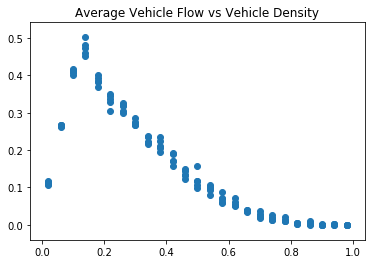

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

densities = np.arange(0.02, 1, 0.04).repeat(5)
flow = [FlowSimulation(100, d, 5, .2).run(n=1000) for d in densities]


plt.scatter(densities, flow)
plt.title("Average Vehicle Flow vs Vehicle Density")
plt.show()

## Always in the Middle Rule

In [81]:
class MiddleRuleSimulation(FlowSimulation):
    def calculate(self):
        
        for i, v in enumerate(self.state):
            if v >= 0:
                d_front, d_back = 1,1

                # find distance to the front and to the back
                while self.state[(i + d_front) % self.length] == -1: d_front += 1
                while self.state[(i - d_back) % self.length] == -1: d_back += 1

                # if distance to front greater than to back, accelerate 1. If less, decelerate one.
                self.state[i] = min(v + 1, self.maxv, d_front - 1) if (d_front + 1 > d_back) else min(max(v - 1, 0), d_front - 1)

                # decrease speed by 1 with probability pslow
                if (self.state[i] > 0 and np.random.random() < self.pslow): self.state[i] -= 1

In [82]:

middle = MiddleRuleSimulation(length = 100, density = 0.1, maxv = 5, pslow = 0.5)
middle.run(30, verbose = True)

.....4.....5.........1.4...........4...............2..4................05................3.....5....
4........3......4.....0....5...........4.............0....5............0.....5..............1.......
....3.......3.......1.0.........5..........3.........0.........3.......1..........5..........1......
.......2.......2.....01..............4........1......1............2.....1..............3......2.....
.........0.......0...0.1.................3.....1......1.............1....1................1.....3...
.........0.......0...0..1...................2...1......1.............0....1................0.......4
...2.....0.......0...0...1....................0..1......1............0.....1...............0........
.....0...1.......0...0....2...................0...1......1...........0......2..............0........
.....0....2......0...0......2.................0....1......1..........0........2............0........
.....0......0....0...0........3...............0.....1......1.........1..........3..........

0.03333333333333333

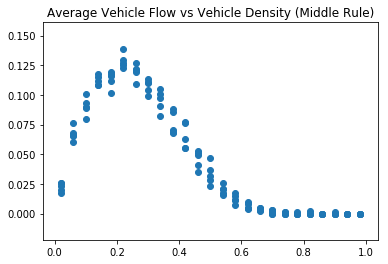

In [83]:
middleflow = [MiddleRuleSimulation(100, d, 5, .2).run(n=1000) for d in densities]

plt.scatter(densities, middleflow)
plt.title("Average Vehicle Flow vs Vehicle Density (Middle Rule)")
plt.show()